### Imports

In [1]:
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

### Generate Points 

In [2]:
mu = [1,2,3] # µ (mean) in 'd' dimension
sigma = [[1,0,0],[0,1,0],[0,0,1]] # Σ (covariance) of 'd' X 'd' dimensions
sample_points = 100

s = np.random.multivariate_normal(mu, sigma, sample_points)
#print(s)

### Probability Distribution Function, Discriminant function and Error Calculation

In [3]:
mu1 = np.array([0,2])
mu2 = np.array([0,3])
sigma = np.matrix([[1,0],[0,1]]) # Identity Matrix, same variance for both distributions
p_w1 = p_w2 = 0.5

rv = {}
#pdf for x when w1 is given i.e. p(x/w1)
rv[1] = multivariate_normal(mu1, sigma)
#pdf for x when w2 is given i.e. p(x/w2)
rv[2] = multivariate_normal(mu2, sigma)
# rv.pdf([x_list]) gives probability for each vector in list

p_w = {1:p_w1, 2:p_w2}

# Generate n samples for a class
def gen_samples(class_label, mu, sigma, n):
    x_wi = np.random.multivariate_normal(mu, sigma, n)
    return [[x, class_label] for x in x_wi]

# Discriminant function for ith class
def g_i(vector,rv,p_wi):
    # g1(x) = log(p(x/wi)) + log(P(wi))
    return math.log(rv.pdf([vector])) + math.log(p_wi)

#Calculate Error
def calc_error(vectors, rv_s, p_wi):
    """
    x: List of feature vectors with class label
    rv_s: Dictionary of PDFs for each class
    p_wi: Dictionary of Priors for each class
    """
    correct_points = 0
    total_points = 0
    for feature_vector,label in vectors:
        g_ = []
        for class_label in rv_s:
            g_.append([g_i(feature_vector, rv_s[class_label], p_wi[class_label]), class_label])
        g_ = sorted(g_, key = lambda x: x[0], reverse = True)
        #Pick class with highest value from discriminant function
        if g_[0][1]==label:
            correct_points += 1
        total_points += 1
    return 1-(correct_points/total_points)

### Bhattacharyya Bound

In [4]:
# Bhattacharya Bound
mu_1 = np.matrix(mu1)
mu_2 = np.matrix(mu2)
k = ( ( (1/8)*(mu_2 - mu_1)*(np.linalg.inv(sigma)))*(mu_2 - mu_1).transpose())[0,0]
perror = 0.5 * math.e**(-1*k)
print(perror)

0.4412484512922977


# Main Run for n = 100, 200, 300 ... 1000

In [5]:
points_list = list(range(100,1001,100))
errors = []
for no_points in points_list:
    w1_points = gen_samples(1, mu1, sigma, int(no_points/2))
    w2_points = gen_samples(2, mu2, sigma, int(no_points/2))
    points_ = w1_points+ w2_points
    err = calc_error(points_,rv, p_w)
    errors.append([err])
errors

[[0.32999999999999996],
 [0.385],
 [0.2833333333333333],
 [0.3025],
 [0.33799999999999997],
 [0.29166666666666663],
 [0.33999999999999997],
 [0.3075],
 [0.30666666666666664],
 [0.30900000000000005]]

# Visualization
### Comparing error with Bhattacharyya Bound

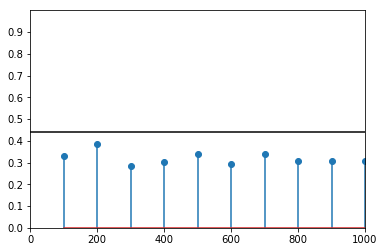

In [6]:
plt.axis([0,1000,0,1])
plt.yticks([i*0.1 for i in range(0,10)])
plt.hlines(perror,0,1000)
plt.stem(points_list,errors)
plt.show()
plt.close()

### Is the bound ever crossed?

In [7]:
pts_list = list(range(2,1001))
errs = []
for no_points in pts_list:
    w1_ = gen_samples(1, mu1, sigma, int(no_points/2))
    w2_ = gen_samples(2, mu2, sigma, int(no_points/2))
    pts_ = w1_+ w2_
    err = calc_error(pts_,rv, p_w)
    errs.append([err])

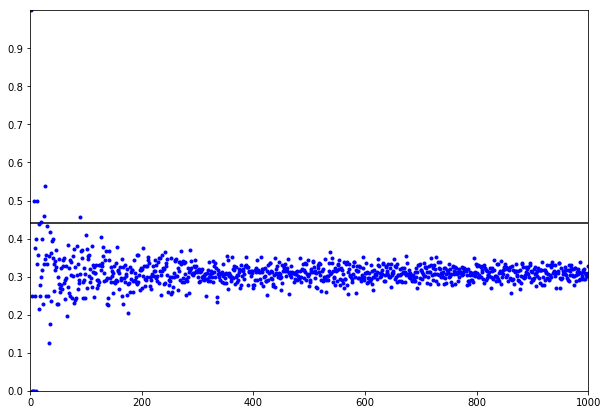

In [10]:
plt.axis([0,1000,0,1])
plt.yticks([i*0.1 for i in range(0,10)])
plt.hlines(perror,0,1000)
plt.plot(pts_list,errs,'b.')
plt.show()

### Visualize the boundary and points

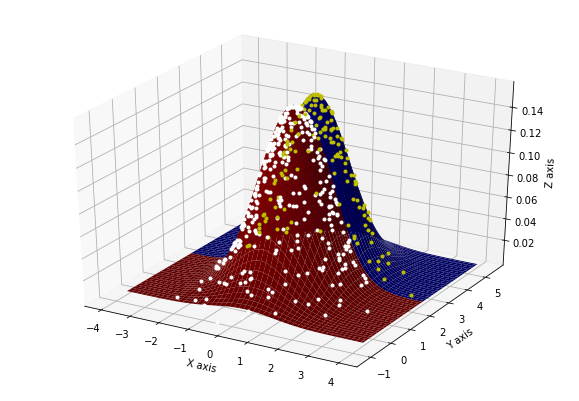

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

from pylab import rcParams
rcParams['figure.figsize'] = 10,7

#Create Mesh
x = np.linspace(-4,4,100)
y = np.linspace(-0.5,5.5,100)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y

#PDF for z-value
rv = multivariate_normal(mu1, sigma)
rv1 = multivariate_normal(mu2, sigma)

z1 = rv.pdf(pos)
z2 = rv1.pdf(pos)
z = np.zeros((100,100,))
zr = np.zeros((100,100,))
for i in range(100):
    for j in range(100):
        z[i][j] = max(z1[i][j],z2[i][j])
        if z1[i][j]==z2[i][j]:
            zr[i][j] = z1[i][j]

#Blue Red for classes
znew = z1-z2
for i in range(len(znew)):
    for j in range(len(znew[i])):
        if znew[i][j]>0:
            znew[i][j] = 1
        elif znew[i][j]==0:
            znew[i][j] = 0.5
        else:
            znew[i][j] = 0

color_dimension = znew
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='jet')
m.set_array([])
fcolors = m.to_rgba(color_dimension)            

#Make a 3D plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, z,facecolors = fcolors,linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

#POINTS GENERATED FOR CLASS 1 ONLY, CHANGE TO w2_points FOR OTHER CLASS
for i in w1_points:
    x_c = i[0][0]
    y_c = i[0][1]
    ac = i[1]
    cc = 1 if rv.pdf(i[0])>rv1.pdf(i[0]) else 0
    if ac==cc:
        ax.plot([x_c], [y_c], max(rv.pdf(i[0]),rv1.pdf(i[0])), 'w.')
    else:
        ax.plot([x_c], [y_c], max(rv.pdf(i[0]),rv1.pdf(i[0])), 'y.')

#WHITE IS CORRECTLY CLASSIFIED
plt.show()